# In this notebook I'm generating the movements and the states variables (torques and angles) in order to produce this movement using the 2dof simulator.

### Some of the algorithms (or inspiration) to simulate the 2dof arm came from: http://www.gribblelab.org/compneuro/

# Here starts the 2 joint arm study

# Main functions to the 2 joint arm simulation

In [2]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

plt.rcParams['figure.figsize'] = 20, 10

import numpy
import sys
import save_load_file as slf

import os

In [3]:
import matplotlib 

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# matplotlib.rcdefaults() # restores to the default values

# http://matplotlib.org/api/matplotlib_configuration_api.html#matplotlib.rc

In [4]:
from simulation_2DoF_Arm_physics import *

## End of the main functions!

# Step-by-step of how to generate the values to the simulations:

In [5]:
# First the arm parametres according to Joshi/Maass paper
aparams = {
    'l1' : 0.5, # metres
    'l2' : 0.5,
    'lc1' : 0.25,
    'lc2' : 0.25,
    'm1' : 1.0, # kg
    'm2' : 1.0,
    'i1' : 0.03, # kg*m*m
    'i2' : 0.03
}

In [6]:
sim_sets = ["set_A", "set_B", "set_C", "set_D"]

sim_set = sim_sets[0]

base_dir = "2DofArm_simulation_data"

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

# Total time spent during the movement (in seconds)
MT = 0.5
# Simulation time step (in seconds)
time_step = 2/1000.0
# Number of neurons at the input layer (defines the resolution of the system)
Ninput = 50

t_mov=numpy.arange(0, MT, time_step) # t starts in 0s and steps time_step(s) until reaches MT(s)

In [7]:
def trajectory_gen(tji):


    xstart,ystart = trajectories[tji-1][0]
    xdest,ydest = trajectories[tji-1][1]

    # Generates the movements according to:
    # Flash, Tamar, and Neville Hogan. 1985
    H_path=cartesian_movement_generation_training(xstart, ystart, xdest, ydest, MT, t_mov)

    # These are the values teta1 and teta2 can have because the system limits the resolution.
    # According to Joshi/Maass paper there are 50 neurons to code the positions of each variable.
    #
    #
    teta1=numpy.linspace(-numpy.pi/6,numpy.pi,num=Ninput)
    teta2=numpy.linspace(0,numpy.pi,num=Ninput)
    teta1_teta2 = numpy.array([teta1,teta2]).T # This is the matrix to use with the function
                                               # to generate the x,y values of the workspace

    # Joint's workspace: all the possible combinations between teta1 and teta2.
    teta_workspace = numpy.array([[t1,t2] for t1 in teta1 for t2 in teta2])

    # Arm's workspace: x,y points that the arm (endpoint) can reach
    H_workspace = joints_to_hand(teta_workspace,aparams)[0] # I'm getting the first because it returns the elbow's positions too.


    # Now I need to fit the H values using the H_workspace ones!
    # What I'm doing here is: I fit the value to the nearest X and Y (individualy) available in the workspace matrix.
    # H_corrected = numpy.array([[H_workspace[:,0][abs(H_workspace[:,0]-xy[0]).argmin()], H_workspace[:,1][abs(H_workspace[:,1]-xy[1]).argmin()]] for xy in H_path])
    # numpy.linalg.norm(H_workspace,axis=1)
    # numpy.linalg.norm(H_workspace-numpy.array([0,1]),axis=1).argmin()

    H_corrected=numpy.array([H_workspace[numpy.linalg.norm(H_workspace-xy,axis=1).argmin()] for xy in H_path]);
    
    
    return H_path,H_workspace,H_corrected

## Here we can see one limitation of an input code that is made os discrete values.  
It's difficult to generate the joint torques for these values because there are too many abrupt changes that would demand huge accelerations.

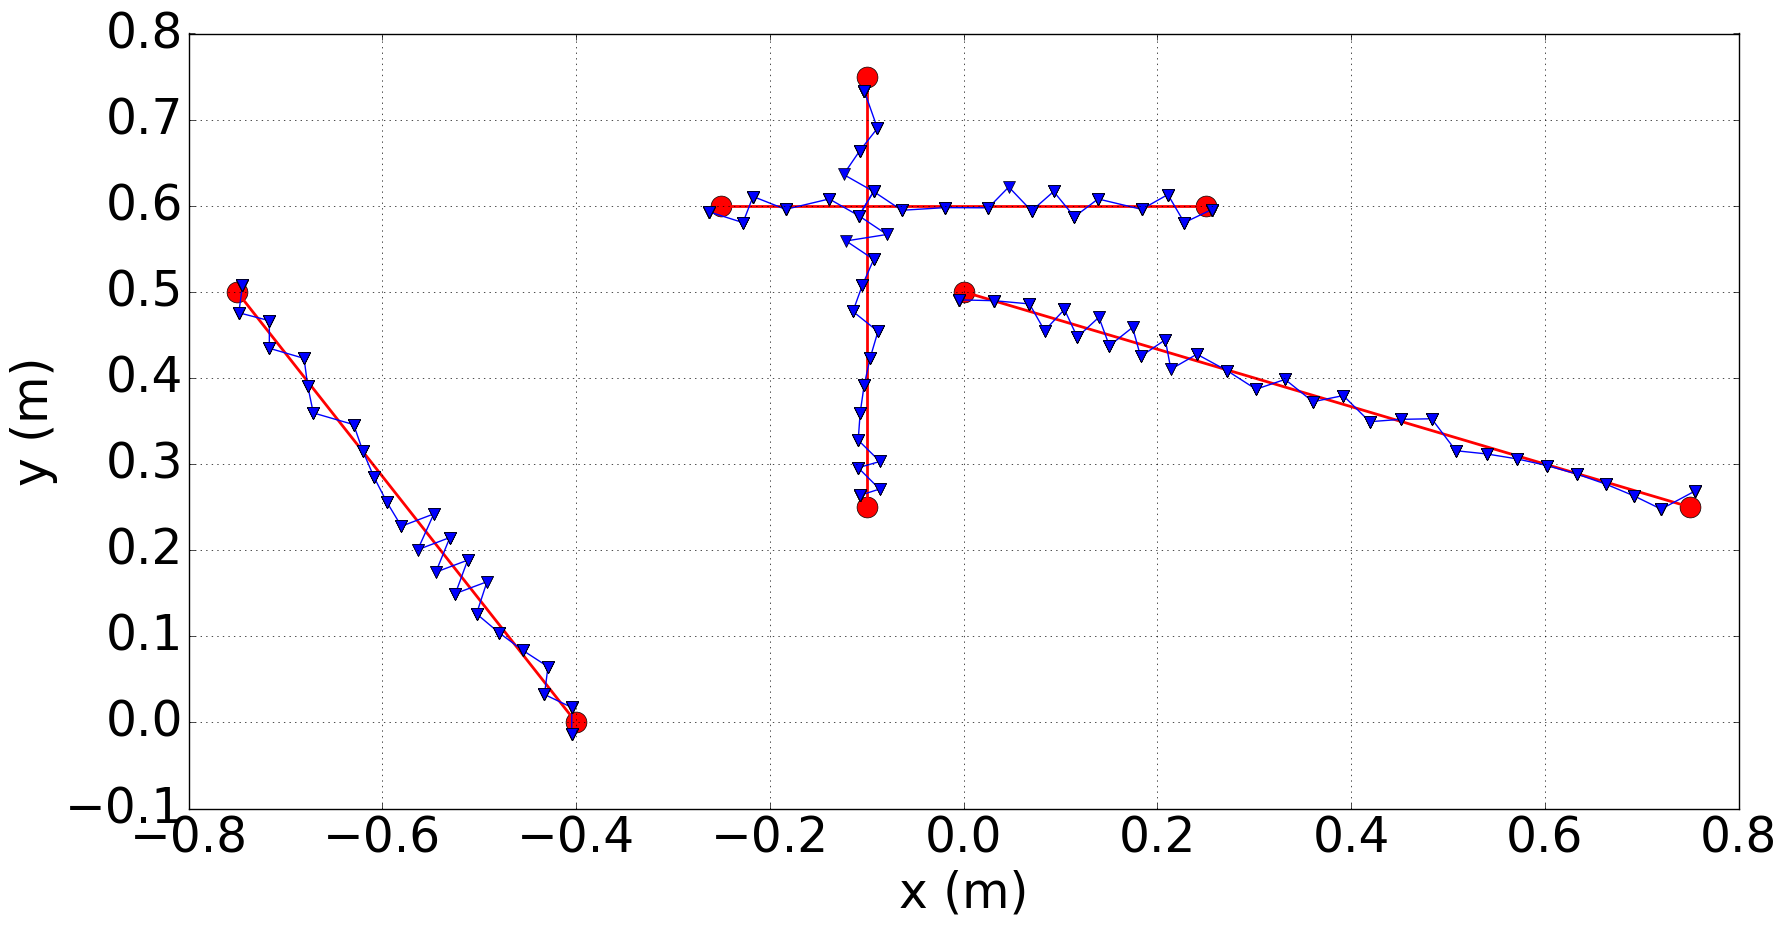

In [8]:
font = {'weight' : 'normal',
        'size'   : 35}

matplotlib.rc('font', **font)


fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)

tji=1
H_path,H_workspace,H_corrected = trajectory_gen(tji)
plt.plot(H_path[0,0],H_path[0,1], 'ro',markersize=15)
plt.plot(H_path[-1,0],H_path[-1,1], 'ro',markersize=15)

plt.plot(H_path[:,0],H_path[:,1],'r',linewidth=2, label="Continuous workspace")
plt.plot(H_corrected[:,0],H_corrected[:,1],'bv-',markersize=8, label="Discrete workspace")

# ax.text(H_path[0,0], H_path[0,1],'('+"{0:.2f}".format(H_path[0,0])+','+"{0:.2f}".format(H_path[0,1])+')',
#         verticalalignment='bottom', horizontalalignment='left',
#         color='blue', fontsize=30)

# ax.text(H_path[-1,0]-0.03, H_path[-1,1]-0.03,'('+"{0:.2f}".format(H_path[-1,0])+','+"{0:.2f}".format(H_path[-1,1])+')',
#         verticalalignment='top', horizontalalignment='right',
#         color='blue', fontsize=30)

tji=2
H_path,H_workspace,H_corrected = trajectory_gen(tji)
plt.plot(H_path[0,0],H_path[0,1], 'ro',markersize=15)
plt.plot(H_path[-1,0],H_path[-1,1], 'ro',markersize=15)

plt.plot(H_path[:,0],H_path[:,1],'r',linewidth=2, label="Continuous workspace")
plt.plot(H_corrected[:,0],H_corrected[:,1],'bv-',markersize=8, label="Discrete workspace")

# ax.text(H_path[0,0], H_path[0,1],'('+"{0:.2f}".format(H_path[0,0])+','+"{0:.2f}".format(H_path[0,1])+')',
#         verticalalignment='bottom', horizontalalignment='left',
#         color='blue', fontsize=30)

# ax.text(H_path[-1,0]-0.03, H_path[-1,1]-0.03,'('+"{0:.2f}".format(H_path[-1,0])+','+"{0:.2f}".format(H_path[-1,1])+')',
#         verticalalignment='top', horizontalalignment='right',
#         color='blue', fontsize=30)

tji=3
H_path,H_workspace,H_corrected = trajectory_gen(tji)
plt.plot(H_path[0,0],H_path[0,1], 'ro',markersize=15)
plt.plot(H_path[-1,0],H_path[-1,1], 'ro',markersize=15)

plt.plot(H_path[:,0],H_path[:,1],'r',linewidth=2, label="Continuous workspace")
plt.plot(H_corrected[:,0],H_corrected[:,1],'bv-',markersize=8, label="Discrete workspace")

# ax.text(H_path[0,0], H_path[0,1],'('+"{0:.2f}".format(H_path[0,0])+','+"{0:.2f}".format(H_path[0,1])+')',
#         verticalalignment='bottom', horizontalalignment='left',
#         color='blue', fontsize=30)

# ax.text(H_path[-1,0]-0.03, H_path[-1,1]-0.03,'('+"{0:.2f}".format(H_path[-1,0])+','+"{0:.2f}".format(H_path[-1,1])+')',
#         verticalalignment='top', horizontalalignment='right',
#         color='blue', fontsize=30)

tji=4
H_path,H_workspace,H_corrected = trajectory_gen(tji)
plt.plot(H_path[0,0],H_path[0,1], 'ro',markersize=15)
plt.plot(H_path[-1,0],H_path[-1,1], 'ro',markersize=15)

plt.plot(H_path[:,0],H_path[:,1],'r',linewidth=2, label="Continuous workspace")
plt.plot(H_corrected[:,0],H_corrected[:,1],'bv-',markersize=8, label="Discrete workspace")

# ax.text(H_path[0,0], H_path[0,1],'('+"{0:.2f}".format(H_path[0,0])+','+"{0:.2f}".format(H_path[0,1])+')',
#         verticalalignment='bottom', horizontalalignment='left',
#         color='blue', fontsize=30)

# ax.text(H_path[-1,0]-0.03, H_path[-1,1]-0.03,'('+"{0:.2f}".format(H_path[-1,0])+','+"{0:.2f}".format(H_path[-1,1])+')',
#         verticalalignment='top', horizontalalignment='right',
#         color='blue', fontsize=30)

# plt.title("Trajectories")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.xlim(-.8,0.8)
plt.ylim(-.1,0.8)
plt.grid()
# plt.legend(loc=0)
plt.savefig(os.getcwd()+"/"+base_dir+"/"+"cartesian_space_trajectory.pdf")
plt.show()

# But, maybe, we could ignore this behaviour because the LSM is going to act as a filter and even with a discrete input code scheme the output can still be a analog variable (there's the membrane filter before the readout).

In [9]:
tji = 1
H_path,H_workspace,H_corrected = trajectory_gen(tji)

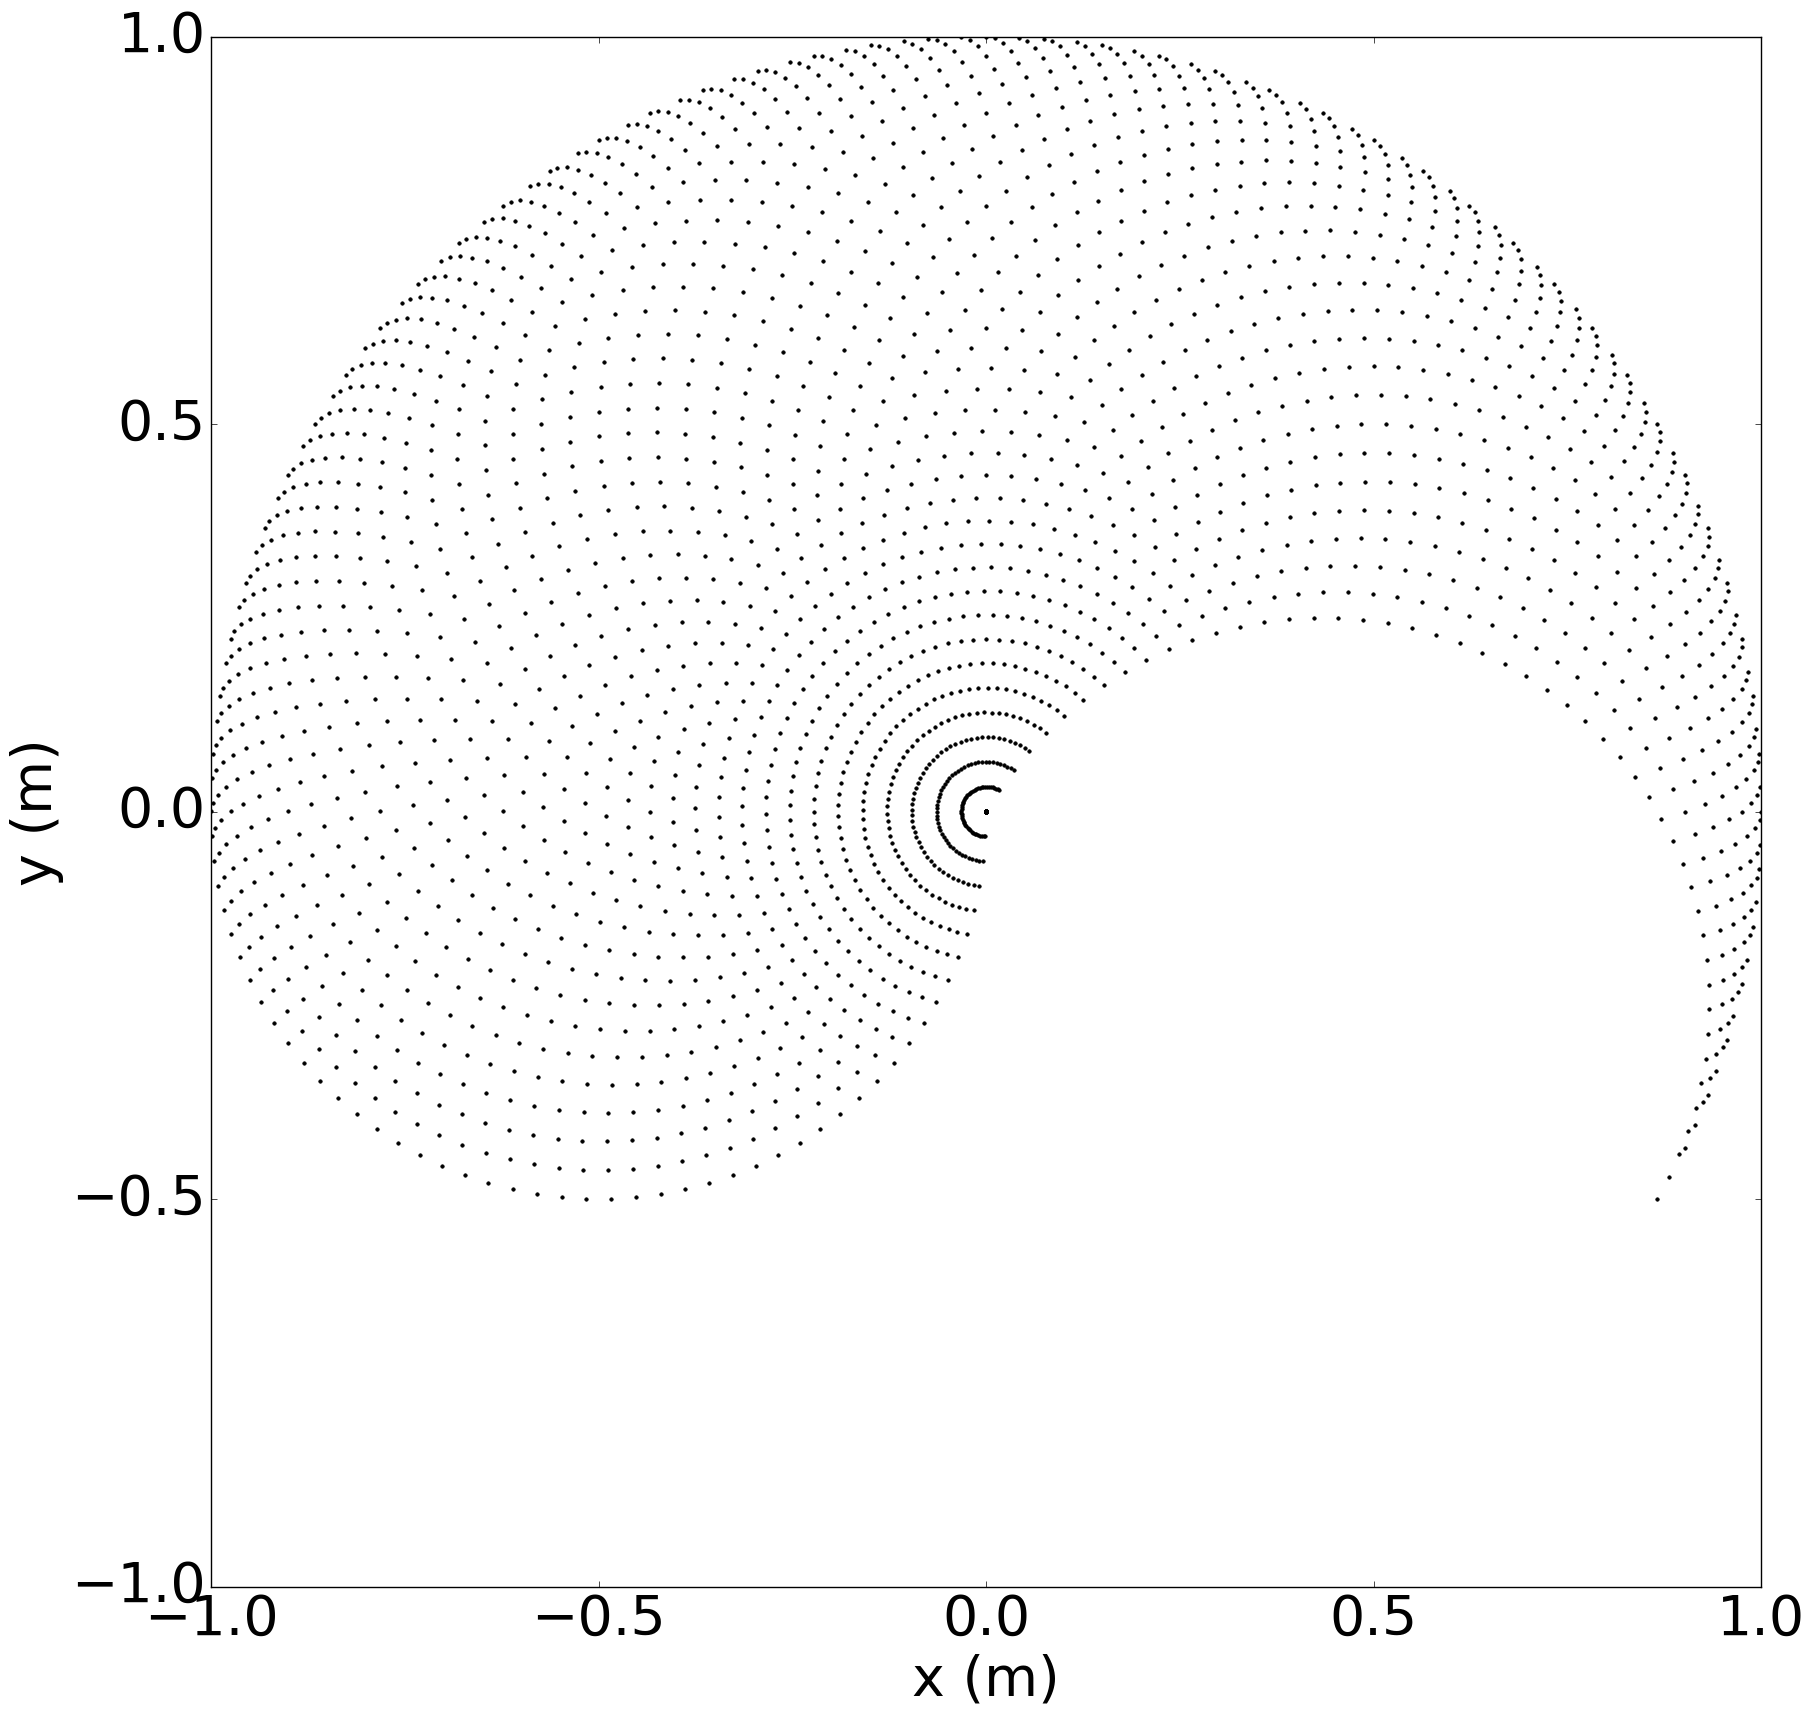

In [10]:
font = {'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)

# Here I'm plotting the possible points the endpoint could reach if:
# Joint 0: [-Pi/6 to Pi, but using only 50 divisions]
# Joint 1: [0 to Pi, but using only 50 divisions]
plt.figure(figsize=(20,20))
plt.plot(H_workspace[:,0],H_workspace[:,1],'k.',markersize=5)
# plt.title("Arm's discretized workspace")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.savefig(os.getcwd()+"/"+base_dir+"/"+"workspace.pdf")
plt.show()

In [11]:
# # Generate the joint's positions according to the fitted (X,Y) values.
# # I'm using the traditional geometric way to do the inverse kinematics here. I need to
# # implement the minimum jerk way to generate the joint's positions taking into account the movement's dynamics.
# Joints_ws=hand_to_joints(H_corrected, aparams,ang_error=0.1)

# # Here "fitted" means positions that are actually possible to be reached using the discrete values available to
# # the two joints (the neuron code limits the joint's angles in 50 different values)

In [12]:
# Generate the joint's positions according to the CONTINUOS (X,Y) values.
# I'm using the traditional geometric way to do the inverse kinematics here. I need to
# implement the minimum jerk way to generate the joint's positions taking into account the movement's dynamics.

Joints=hand_to_joints(H_path, aparams, ang_error=0.1)

In [13]:
# Here I'm extending the Joints matrix because I need two extra positions to calculate the accelerations.
# Consequently, because the trajectory always finish with velocity ZERO, keeping the same position seems a good choice. 
Joints_extended=numpy.concatenate((Joints,[Joints[-1],Joints[-1]]))

# Joints_ws_extended=numpy.concatenate((Joints_ws,[Joints_ws[-1],Joints_ws[-1]]))

# But the time array (t_mov) must be extended too:
t_mov_extended=numpy.concatenate((t_mov,[t_mov[-1]+time_step],[t_mov[-1]+2*time_step]))

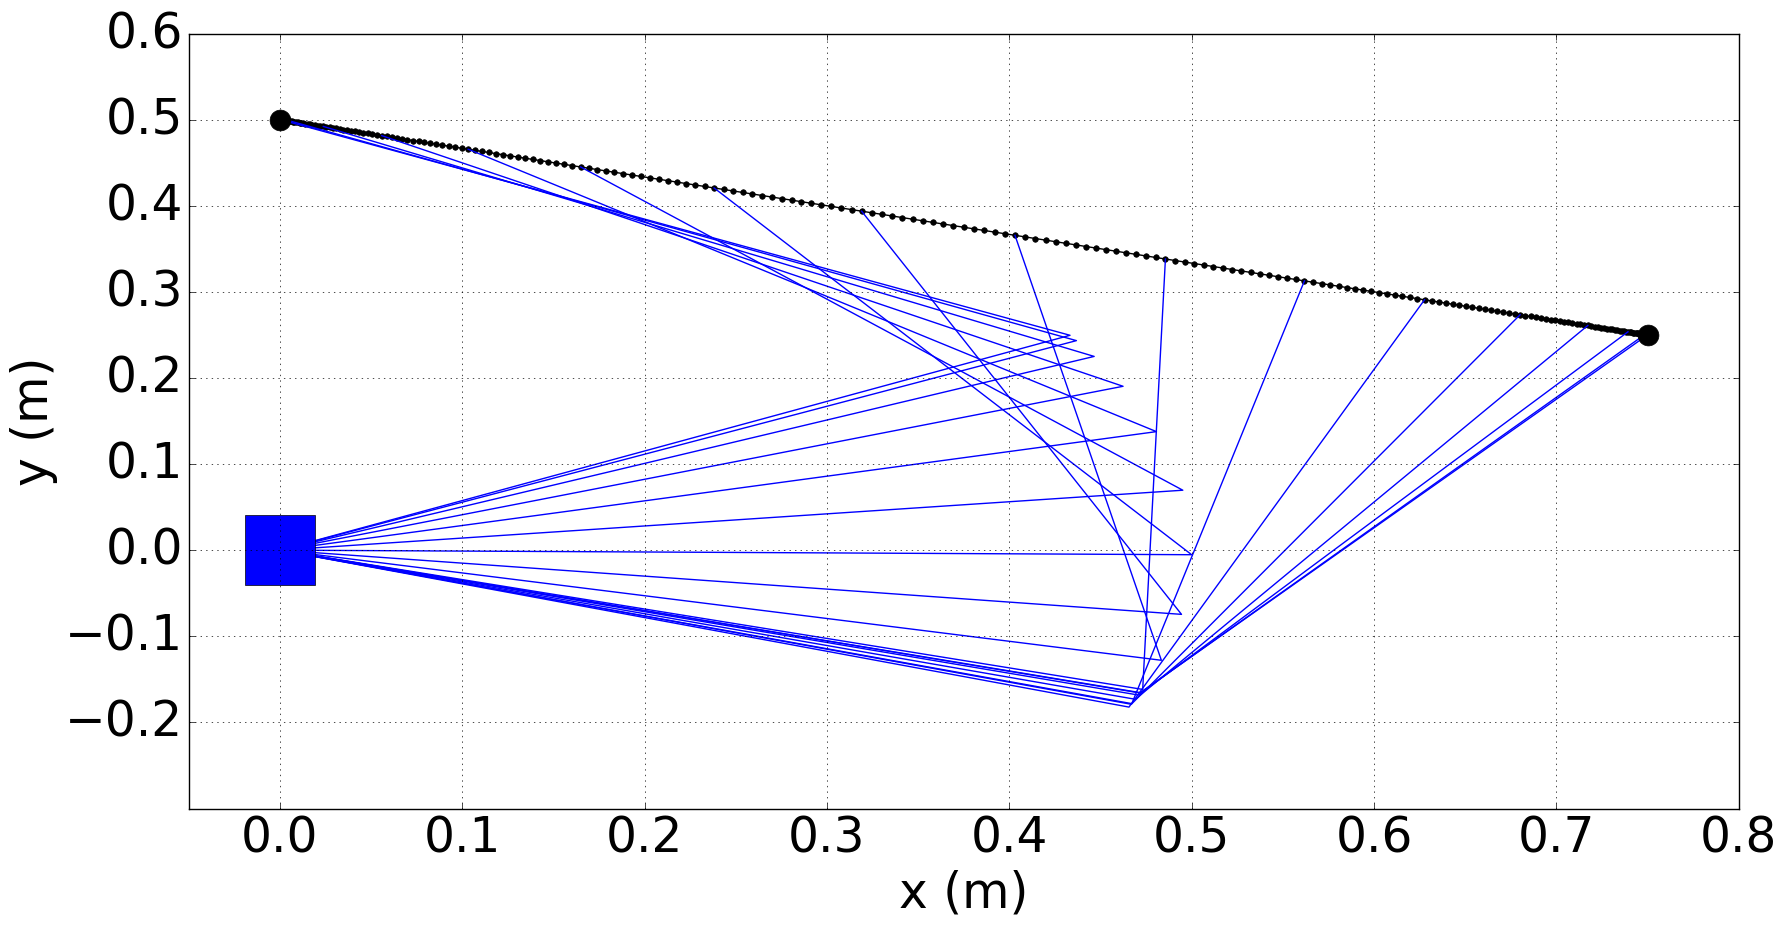

In [14]:
font = {'weight' : 'normal',
        'size'   : 35}

matplotlib.rc('font', **font)


# H_plot_ws,E_plot_ws=joints_to_hand(Joints_ws, aparams) # Generates the data used to draw the arm using the valid joint positions
H_plot,E_plot=joints_to_hand(Joints, aparams) # Generates the data used to draw the arm using the valid joint positions

step_plot = 15

plt.figure(figsize=(20,10))
plt.plot(H_plot[:,0],H_plot[:,1],'k.-', markersize=8)
for i in range(0,len(E_plot),step_plot):
    plt.plot((0,E_plot[i,0],H_plot[i,0]),(0,E_plot[i,1],H_plot[i,1]),'b-')

plt.plot(H_path[0,0],H_path[0,1], 'ko',markersize=15)
plt.plot(H_path[-1,0],H_path[-1,1], 'ko',markersize=15)

plt.plot([0],[0],'s',markersize=50)
# plt.title("Arm generating the trajectory (continuous workspace) - Trajectory " + str(tji))
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.xlim(-.05,.8)
plt.ylim(-.3,.6)
plt.grid()
plt.savefig(os.getcwd()+"/"+base_dir+"/"+"continuous_workspace_trajectory.pdf")
plt.show()

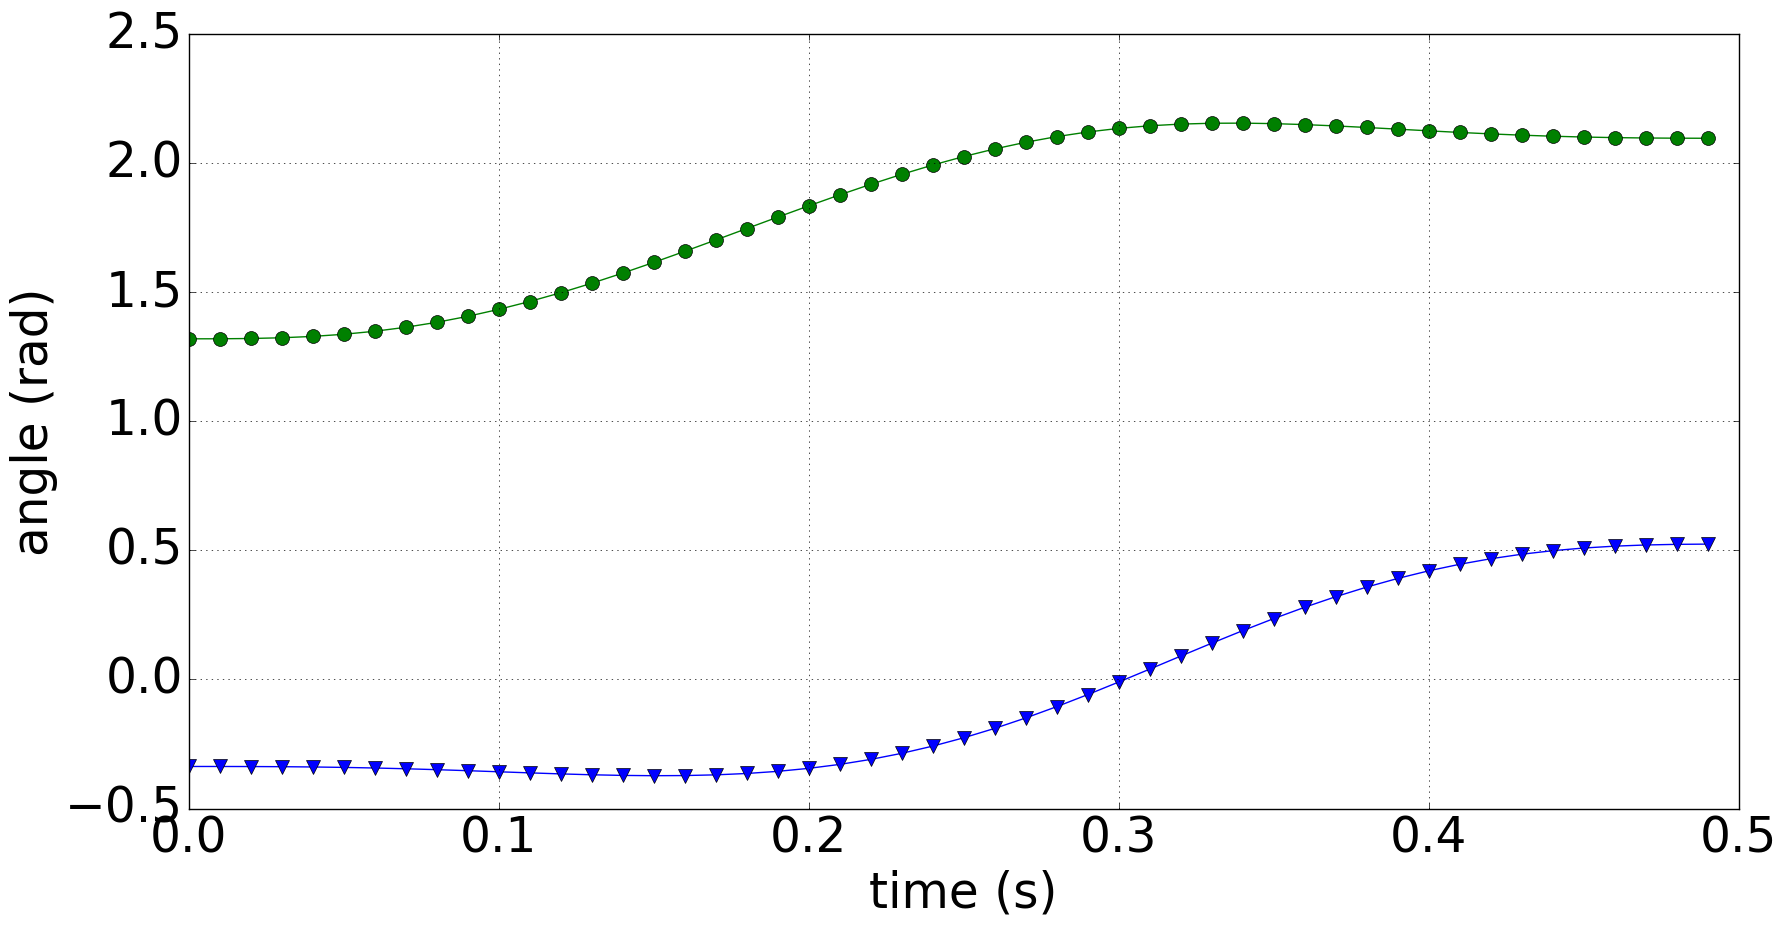

In [15]:
plt.figure()
plt.plot(t_mov[::5],Joints[::5,0],'bv-',label="Joint 1", markersize=10)
plt.plot(t_mov[::5],Joints[::5,1],'go-',label="Joint 2", markersize=10)
# plt.title("Joints (continuous workspace) - Trajectory " + str(tji))
plt.xlabel("time (s)")
plt.ylabel("angle (rad)")
# plt.legend(loc=4)
plt.grid()
plt.savefig(os.getcwd()+"/"+base_dir+"/"+"continouous_workspace_joints.pdf")
plt.show()

In [16]:
# Joint's velocities
# teta1_d=numpy.concatenate((derivator(Joints[:,0],t_mov),[0]))
# teta2_d=numpy.concatenate((derivator(Joints[:,1],t_mov),[0]))
teta1_d=derivator(Joints_extended[:,0],t_mov_extended)
teta2_d=derivator(Joints_extended[:,1],t_mov_extended)

# teta1_ws_d=derivator(Joints_ws_extended[:,0],t_mov_extended)
# teta2_ws_d=derivator(Joints_ws_extended[:,1],t_mov_extended)

In [17]:
teta1_d[0],teta1_d[-2],teta2_d[0],teta2_d[-2],teta1_d.shape

(-0.00013766465750686407, 0.0, 0.00065702919571641871, 0.0, (251,))

In [18]:
# # # Low-pass filtered joint's velocities
# teta1_d_adj = moving_average(teta1_d)
# teta2_d_adj = moving_average(teta2_d)

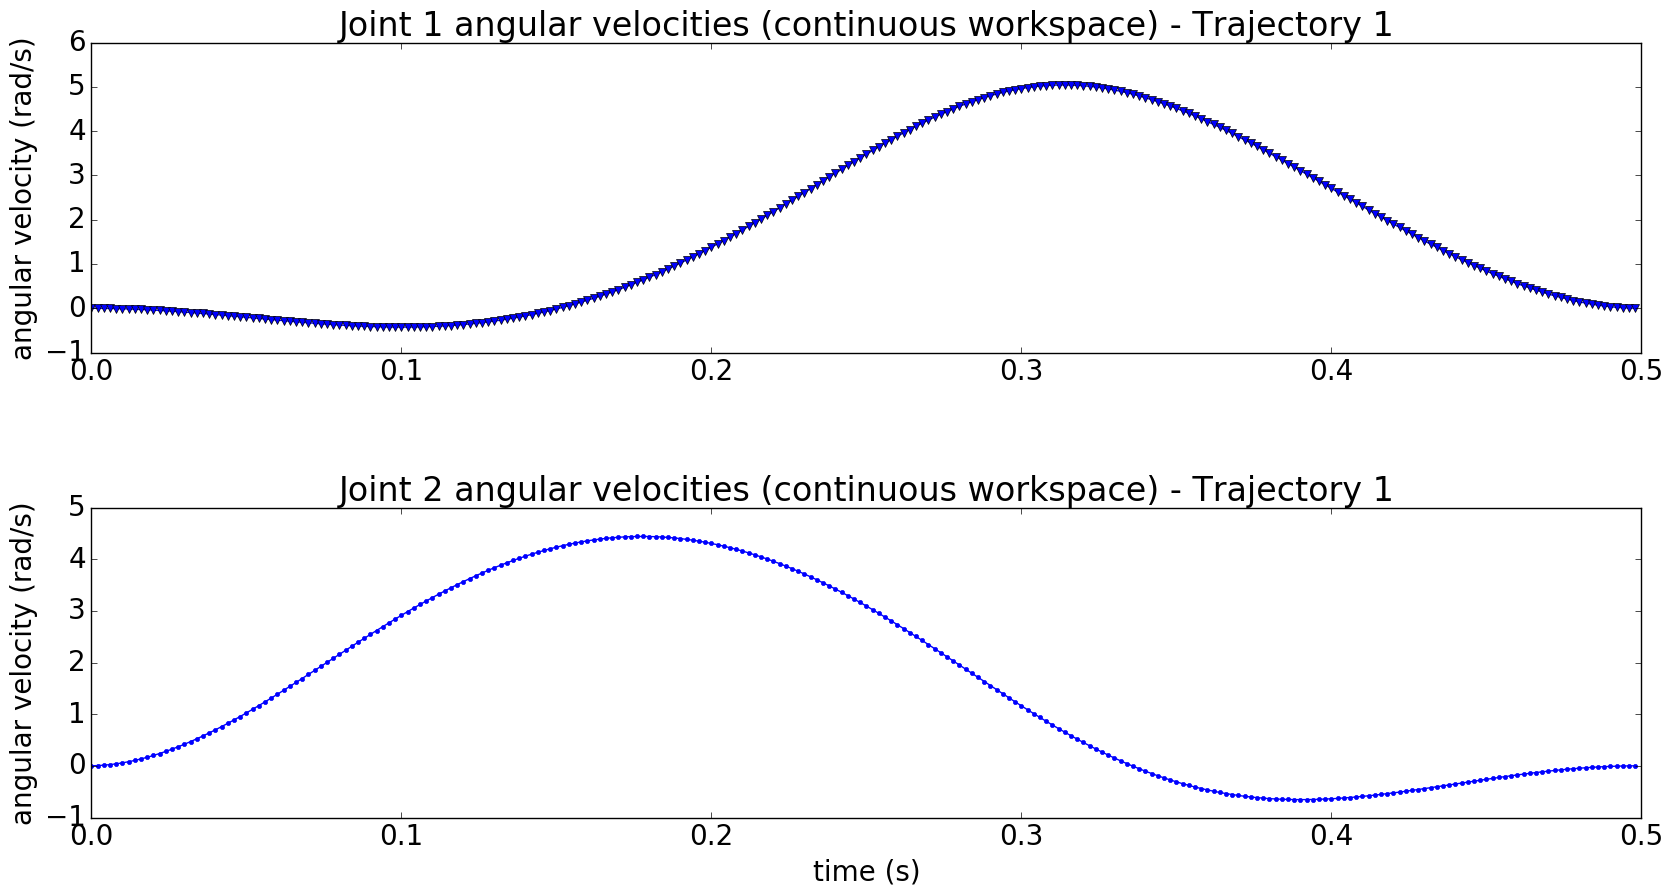

In [19]:
font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

fig=plt.figure()
plt.subplot(211)
plt.plot(t_mov,teta1_d[:250],'bv-')
# plt.plot(t_mov,teta1_d_adj[:250],'g.-')
plt.title("Joint 1 angular velocities (continuous workspace) - Trajectory " + str(tji))
plt.ylabel("angular velocity (rad/s)")

plt.subplot(212)
plt.plot(t_mov,teta2_d[:250],'b.-')
# plt.plot(t_mov,teta2_d_adj[:250],'g.-')
plt.title("Joint 2 angular velocities (continuous workspace) - Trajectory " + str(tji))
plt.ylabel("angular velocity (rad/s)")
plt.xlabel("time (s)")
fig.subplots_adjust(hspace=.5) # Adjust the distance between subplots
# plt.savefig(os.getcwd()+"/"+base_dir+"/"+"continuous_workspace_joints_veloc_"+str(tji)+".pdf")
plt.show()

In [20]:
# Joint's accelerations (with CONTINUOUS joint's velocities)
teta1_dd=derivator(teta1_d,t_mov_extended[:251])
teta2_dd=derivator(teta2_d,t_mov_extended[:251])

# # Joint's accelerations (with DISCRETE joint's velocities)
# teta1_ws_dd=derivator(teta1_ws_d,t_mov_extended[:251])
# teta2_ws_dd=derivator(teta2_ws_d,t_mov_extended[:251])

In [21]:
teta1_dd[0],teta1_dd[-1],teta2_dd[0],teta2_dd[-1]

(-0.40967822831361467, 0.0, 1.9552897002061975, 0.0)

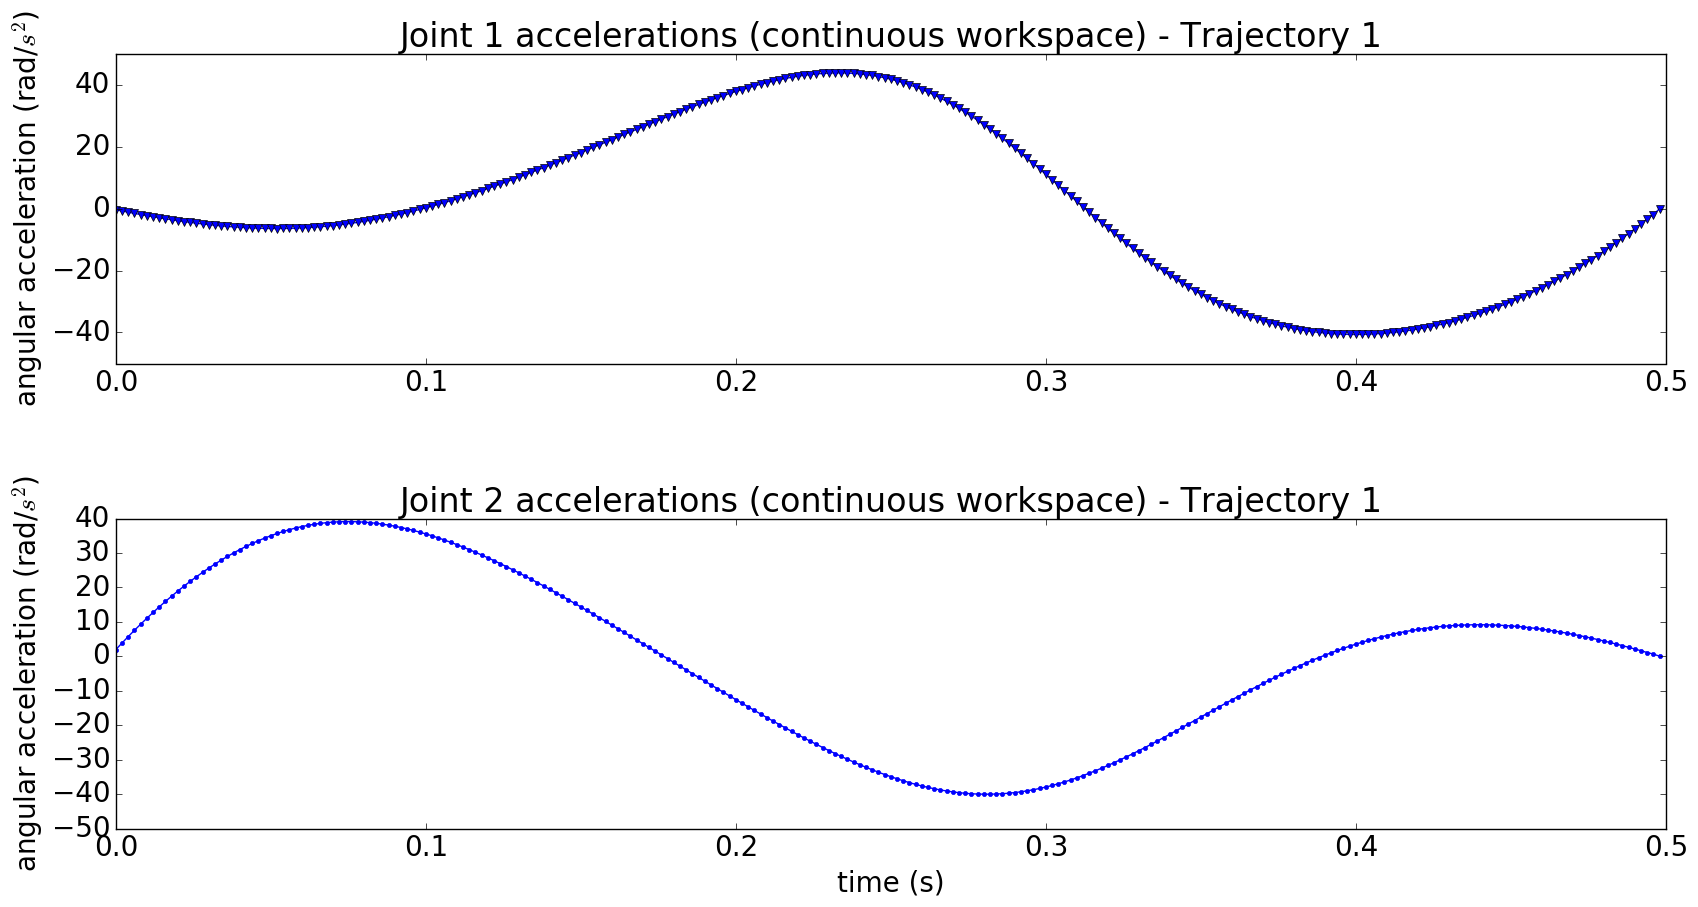

In [22]:
fig=plt.figure()
plt.subplot(211)
plt.plot(t_mov,teta1_dd,'bv-')
plt.title("Joint 1 accelerations (continuous workspace) - Trajectory " + str(tji))
plt.ylabel("angular acceleration (rad/$s^2$)")

plt.subplot(212)
plt.plot(t_mov,teta2_dd,'b.-')
plt.title("Joint 2 accelerations (continuous workspace) - Trajectory " + str(tji))
plt.ylabel("angular acceleration (rad/$s^2$)")
plt.xlabel("time (s)")

fig.subplots_adjust(hspace=.5) # Adjust the distance between subplots
# plt.savefig(os.getcwd()+"/"+base_dir+"/"+"continuous_workspace_joints_acc_"+str(tji)+".pdf")
plt.show()

In [23]:
#
# WITH CONTINUOUS JOINT'S VELOCITIES
#

# And generates a matrix with [teta1,teta2,teta1d,teta2d,teta1dd,teta2dd]
# Using this matrix I will generate the torques.
states_mov = numpy.array([[Joints[:,0][i],Joints[:,1][i],teta1_d[i],teta2_d[i],teta1_dd[i],teta2_dd[i]] for i in range(len(Joints[:,0]))])

#
# WITH DISCRETE JOINT'S VELOCITIES
#

# And generates a matrix with [teta1,teta2,teta1d,teta2d,teta1dd,teta2dd]
# Using this matrix I will generate the torques.
# states_mov_ws = numpy.array([[Joints_ws[:,0][i],Joints_ws[:,1][i],teta1_ws_d[i],teta2_ws_d[i],teta1_ws_dd[i],teta2_ws_dd[i]] for i in range(len(Joints_ws[:,0]))])

In [24]:
#
# WITH FILTERED JOINT'S VELOCITIES
#

# And generates a matrix with [teta1,teta2,teta1d,teta2d,teta1dd,teta2dd]
# Using this matrix I will generate the torques.
# states_mov = numpy.array([[Joints[:,0][i],Joints[:,1][i],teta1_d_adj[i],teta2_d_adj[i],teta1_dd[i],teta2_dd[i]] for i in range(len(Joints[:,0]))])

In [25]:
# Applying the function to all lines of the states_mov matrix, I generate the torques matrix
T_mov=numpy.array([twojointarm_torques(states_mov[i], t_mov, aparams) for i in range(numpy.shape(states_mov)[0])])

# Applying the function to all lines of the states_mov matrix, I generate the torques matrix
# T_mov_ws=numpy.array([twojointarm_torques(states_mov_ws[i], t_mov, aparams) for i in range(numpy.shape(states_mov_ws)[0])])

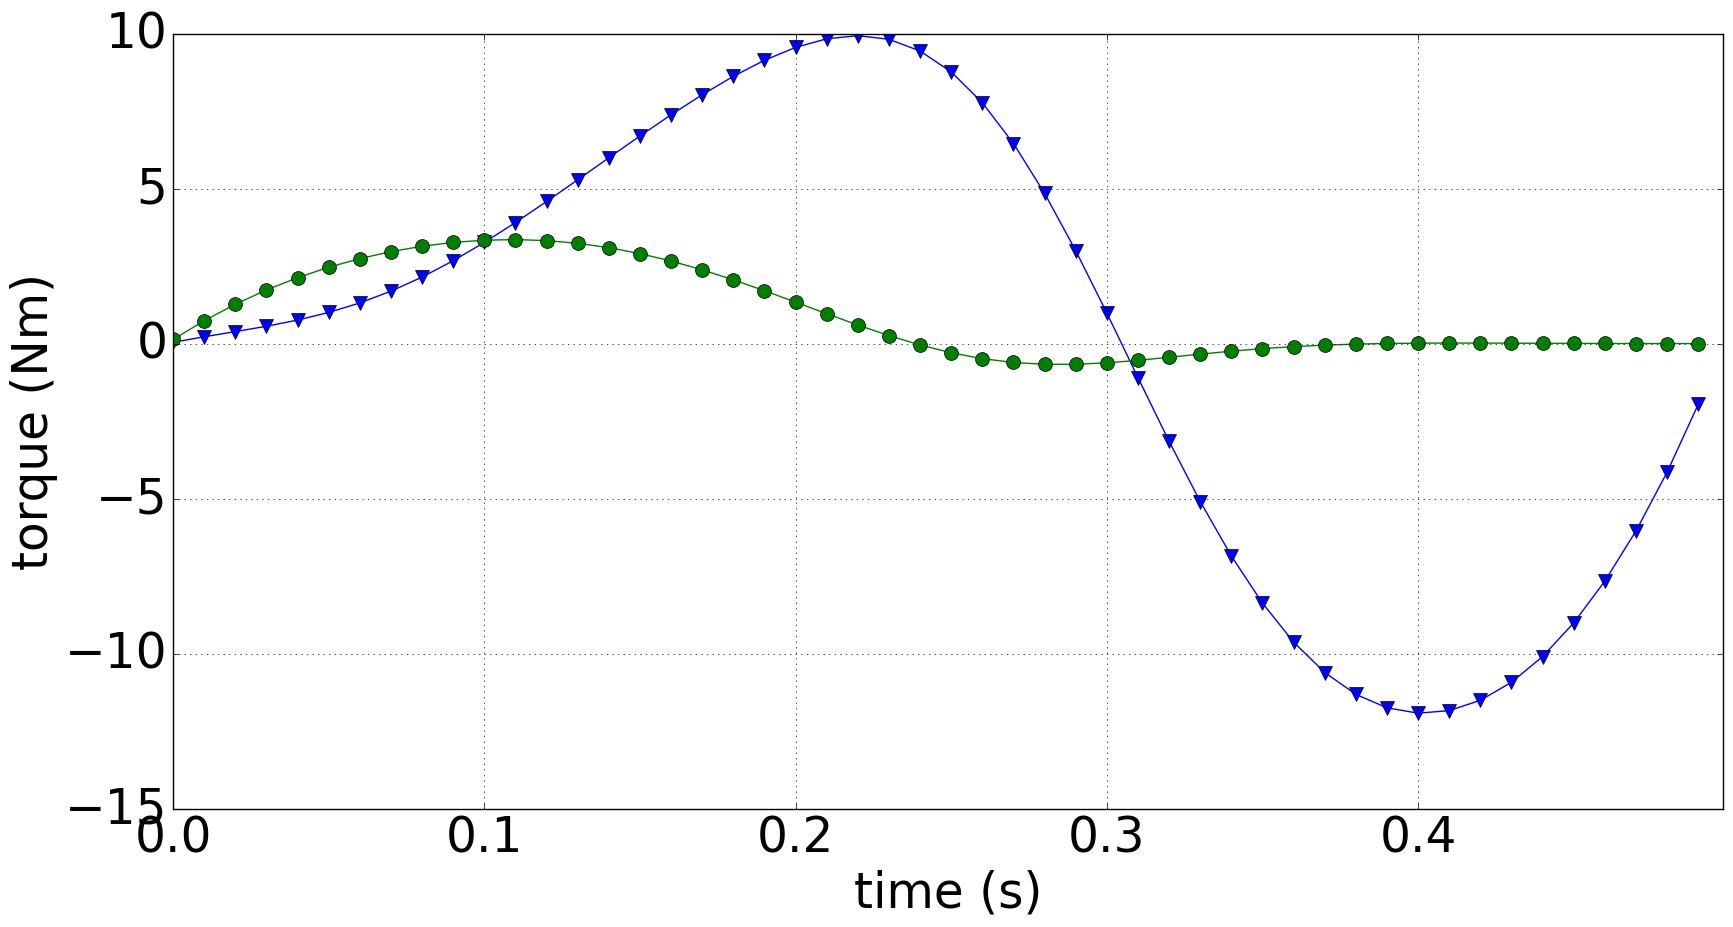

In [26]:
font = {'weight' : 'normal',
        'size'   : 35}

matplotlib.rc('font', **font)

# Torques

plt.figure()
plt.plot(t_mov[::5],T_mov[::5,0],'bv-', label="Torques Joint 1", markersize=10)
plt.plot(t_mov[::5],T_mov[::5,1],'go-', label="Torques Joint 2", markersize=10)
# plt.title("Torques (continuous workspace) - Trajectory " + str(tji))
plt.xlabel("time (s)")
plt.ylabel("torque (Nm)")
plt.xlim(t_mov[0],t_mov[-1])
# plt.legend()
plt.grid()
plt.savefig(os.getcwd()+"/"+base_dir+"/"+"continuous_workspace_joints_torques.pdf")
plt.show()

In [27]:
# Here I calculate the states using the calculated torques, just to make sure it is working!
state = states_mov[0,[0,1,2,3]] # This is the initial state. The rest of the states will be generated dynamically 
                                # according to the input torques.
state_v2 = []
t = t_mov
torque = T_mov
for i in range(len(t)-1):
#     print "state:",state
    state = odeint_arms(twojointarm, state, [t[i], t[i+1]], aparams, torque[i])[1]
    state_v2.append(state)

state_v2=numpy.array(state_v2)

In [28]:
# # import save_load_file as slf
# tji=0
# slf.save_to_file_gz(numpy.array([state_v2,torque]),"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(tji)+".gzpickle")
# # slf.save_to_file_gz(numpy.array([states_mov[:,[0,1,2,3]],T_mov]),"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(tji)+".gzpickle")

In [30]:
state_v2.shape

(249, 4)

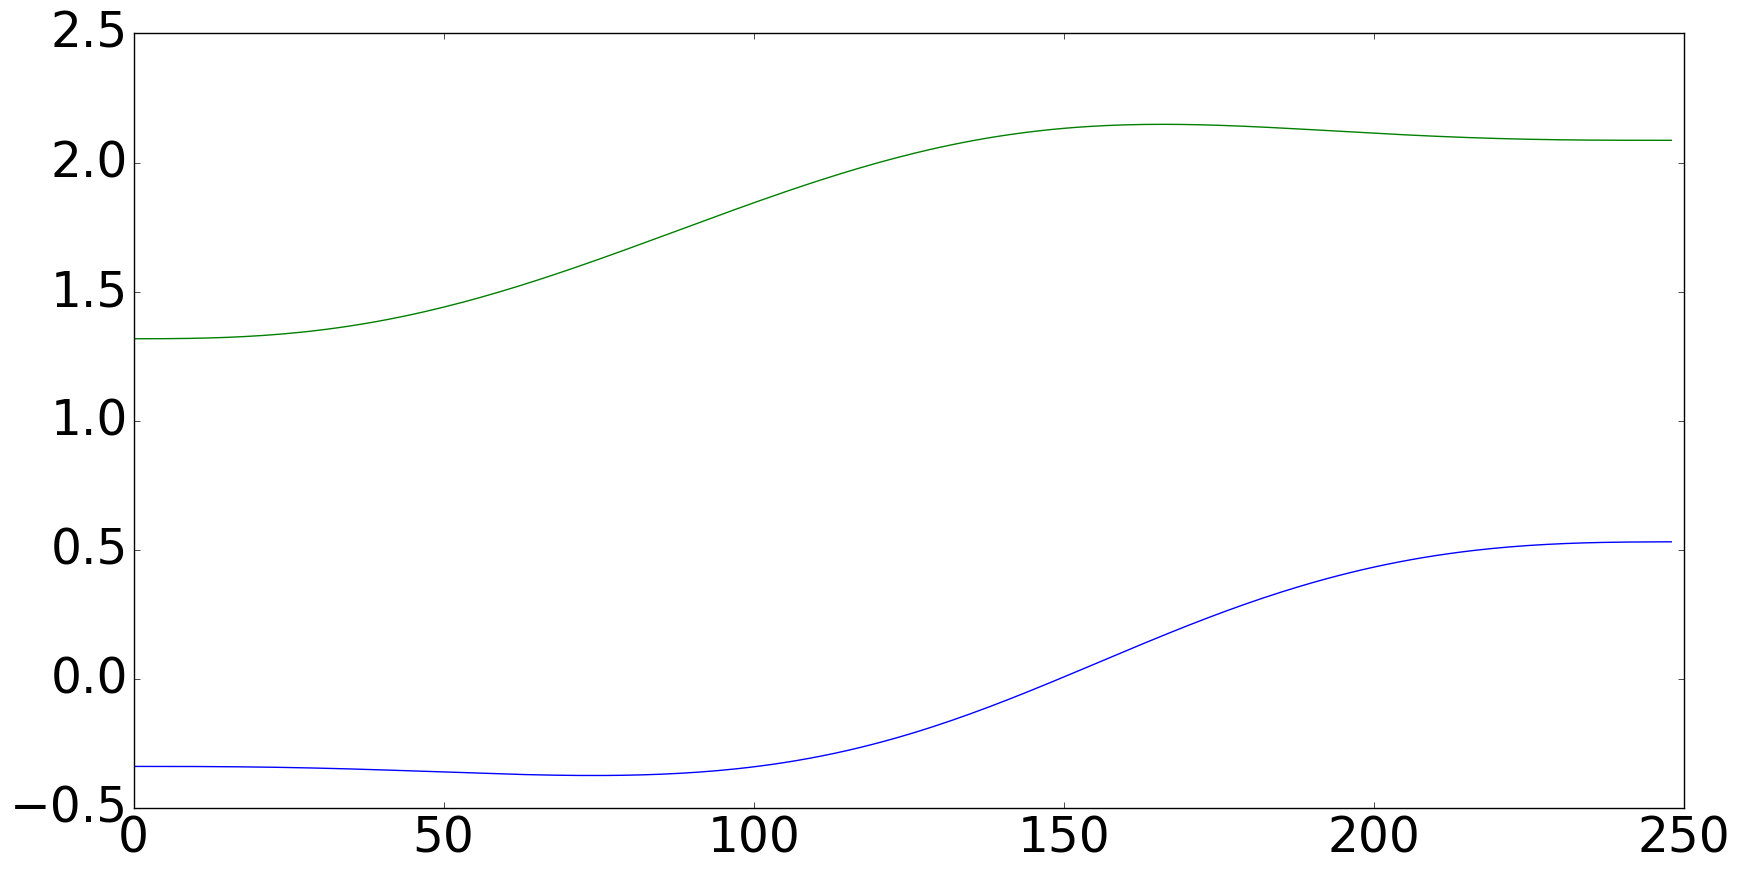

In [41]:
plt.plot(state_v2[:,0])
plt.plot(state_v2[:,1])
plt.show()

In [36]:
H_calc = joints_to_hand(state_v2[:,[0,1]],aparams)[0] # I'm getting the first because it returns the elbow's positions too.

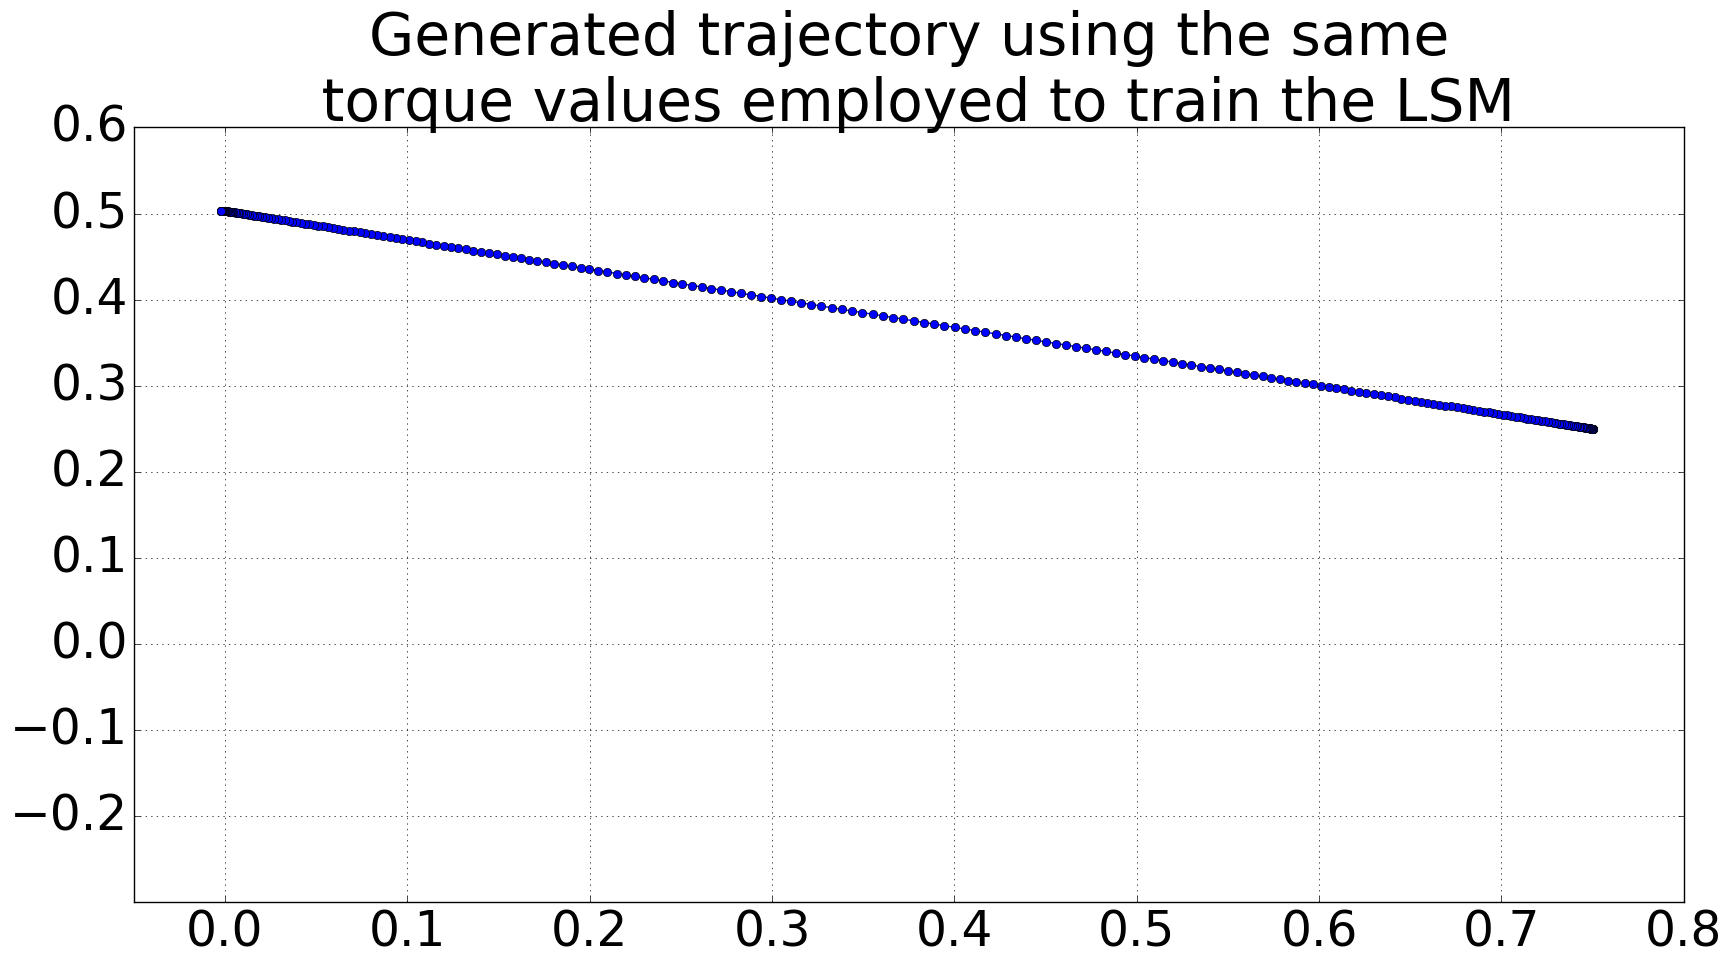

In [44]:
plt.plot(H_calc[:,0],H_calc[:,1],'o-')
plt.xlim(-.05,.8)
plt.ylim(-.3,.6)
plt.grid()
plt.title("Generated trajectory using the same\n torque values employed to train the LSM")
plt.show()